In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
import expipe
import os
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import dataloader as dl
from utils import *

In [3]:
project = expipe.get_project(dl.project_path())
project.actions

### Load tracking data, and spike metadata

In [9]:
lim = [0,1200] # limit recording times - in seconds
action_id = '011-120321-2'
spikes = dl.load_spiketrains(action_id, load_spikes=True, lim=lim, identify_neurons=True)
a,at = dl.load_head_direction(action_id, lim=lim).T
x,y,t,_ = dl.load_tracking(action_id, lim=lim, ca2_transform_data=True).T

In [5]:
social_types = social_label(spikes[0])
box_locations = ~(social_types== -1) # True where there is 'box', false on 'nobox'
box_idx_masks = np.append(box_locations, False)
cms = corner_masks(x=x, y=y, margin=0.4)
sm1,sm2 = cms[:,box_idx_masks].T
nsm = np.sum(cms[:,~box_idx_masks], axis=-1).astype(bool) # union of rest of space

### Visualise tracking and socializing

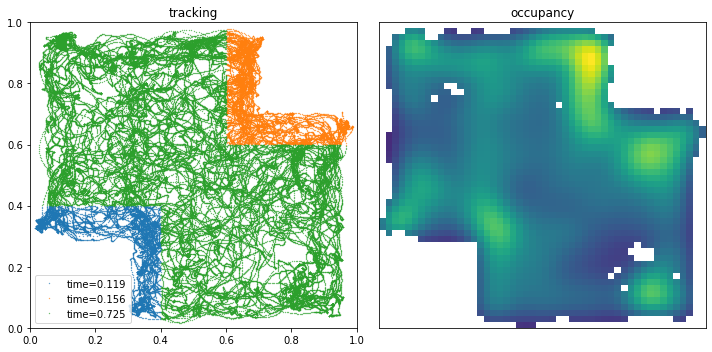

In [6]:
# calculate relative time spent in different parts of box
times = list(map(lambda x: np.sum(x), iter((sm1, sm2, nsm))))
fraction_times = np.around(np.array(times) / len(t), 3)

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
coords = np.stack([x,y],axis=-1)
axs[0].plot(x[sm1],y[sm1], 'o', markersize=0.3, label='time={}'.format(fraction_times[0]))
axs[0].plot(x[sm2],y[sm2], 'o', markersize=0.3, label='time={}'.format(fraction_times[1]))
axs[0].plot(x[nsm],y[nsm], 'o', markersize=0.3, label='time={}'.format(fraction_times[2]))
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].set_title('tracking')

spatial_map = sp.SpatialMap()
occupancy_map = spatial_map.occupancy_map(x, y, t)
#occupancy_map = np.rot90(occupancy_map)
axs[1].imshow(occupancy_map.T, vmin=0, aspect="auto", origin='lower')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('occupancy')

plt.tight_layout()
# default is Downloads folder, but can use any folder :) 
#plt.savefig("/Users/sarahht/Downloads/denne.png") #evt .pdf

### Visualise head direction and different zones

---
**OBSOBS!**

The head directions displayed below is not "correct"!
They are not with respect to the cardinal box-axes. 
In other words, **YOU CAN NOT INTERPRET THEM IN REFERENCE TO
THE PHYSICAL DISTANCES OF THE BOX.**

**OBSOBS!**

---

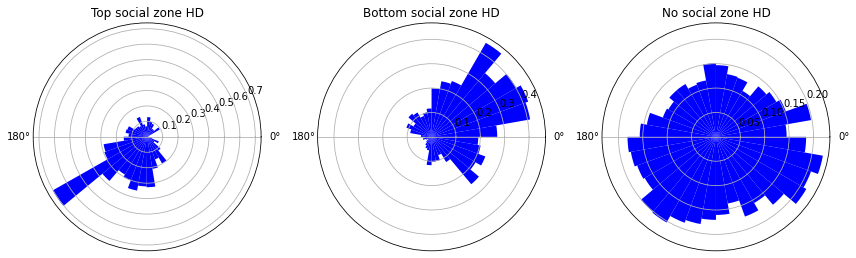

In [7]:
def head_direction_binned(a, bins=36, density=True):
    # circular histogram/bar-plot
    hist, bin_edges = np.histogram(a, bins=36, density=True)
    hist[np.isnan(hist)] = 0.0 # no data for this head-direction => height of bar = 0.0
    binwidth=(bin_edges[1]-bin_edges[0])
    bin_centers = bin_edges[1:] - binwidth/2
    return {'x': bin_centers, 'height': hist, 'width': binwidth}

# initialise plots
from matplotlib import gridspec
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(nrows=1,ncols=3)
axs = [fig.add_subplot(gs[0,i],projection='polar') for i in range(3)]

for ax in axs:
    ax.set_xticks([0, np.pi])
    #ax.set_rmax(2)
    #ax.set_rticks([0.25, 0.5, 0.75, 1.0])  # Less radial ticks
    #ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
    #ax.grid(True)

# interpolate masks to fit angle times
f_mask = lambda mask: scipy.interpolate.interp1d(t, mask, kind='linear', fill_value='extrapolate')(at).astype(bool)
    
# do plotting and invidual tuning
axs[0].bar(**head_direction_binned(a[f_mask(sm1)]),color='b')
axs[0].set_title('Top social zone HD')
axs[1].bar(**head_direction_binned(a[f_mask(sm2)]),color='b')
axs[1].set_title('Bottom social zone HD')
axs[2].bar(**head_direction_binned(a[f_mask(nsm)]),color='b')
axs[2].set_title('No social zone HD')
plt.tight_layout()

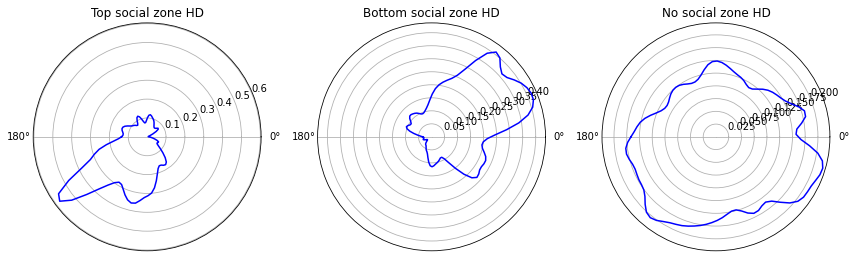

In [8]:
def vonmises_kde(data, kappa=100, n_bins=100):
    # Kernel Density Estimation - continuous equivalent of a histogram
    from scipy.special import i0
    x = np.linspace(-np.pi, np.pi, n_bins)
    if len(data) == 0:
        return [], []
    # integrate vonmises kernels
    kde = np.exp(kappa * np.cos(x[:, None] - data[None, :])).sum(1) / (2 * np.pi * i0(kappa))
    kde /= np.trapz(kde, x=x)
    return x, kde

from matplotlib import gridspec
fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(nrows=1,ncols=3)
axs = [fig.add_subplot(gs[0,i],projection='polar') for i in range(3)]
[ax.set_xticks([0, np.pi]) for ax in axs]

axs[0].plot(*vonmises_kde(a[f_mask(sm1)]),color='b')
axs[0].set_title('Top social zone HD')
axs[1].plot(*vonmises_kde(a[f_mask(sm2)]),color='b')
axs[1].set_title('Bottom social zone HD')
axs[2].plot(*vonmises_kde(a[f_mask(nsm)]),color='b')
axs[2].set_title('No social zone HD')
plt.tight_layout()